In [1]:
import numpy as np
import pandas as pd
import feather

from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.options.display.max_columns = 60
plt.style.use("tableau-colorblind10")

For details on how the dataframe was cleaned see gstore_revenue_cleaning. 

#### NOTE: Revenue has already been logtransformed here, so the numbers quoted will be Log(Transaction Revenue +1). For convenience will sometimes just refer to it as revenue

In [20]:
train_df = feather.read_dataframe('data/clean_train_v2.feather')

In [21]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour,totals.sessionQualityDim,totalUserRev,spender
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1,1,1,1,1,None,0.0,(not set),google,organic,False,True,0,16,10,2017,0,None,0.000000,False
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),1,2,2,0,0,28,0.0,(not set),sites.google.com,referral,False,True,0,16,10,2017,17,None,32.743829,True
2,Referral,2017-10-16,8934116514970143966,1508160211,5,1508160211,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),1,2,2,0,0,15,0.0,(not set),(direct),(none),True,True,0,16,10,2017,13,None,32.743829,True
3,Referral,2017-11-30,8934116514970143966,1512072970,7,1512072970,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),1,3,3,0,0,43,0.0,(not set),(direct),(none),False,True,3,30,11,2017,20,None,32.743829,True
4,Referral,2017-09-22,8934116514970143966,1506112800,3,1506112800,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),1,2,2,0,0,None,0.0,(not set),(direct),(none),True,True,4,22,9,2017,20,2,32.743829,True


# Initial Exploratory Analysis

## Target Variable Distributions

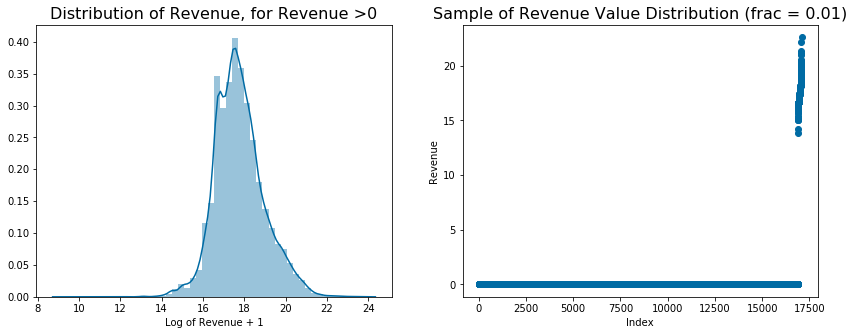

In [22]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"],hist = True, bins = 50)
ax.set_xlabel('Log of Revenue + 1')
ax.set_title('Distribution of Revenue, for Revenue >0', fontsize = 16)

plt.subplot(1,2,2)
plt.scatter(range(train_df.sample(frac = 0.01, random_state = 1).shape[0]), np.sort(train_df.sample(frac = 0.01, random_state = 1)['totals.transactionRevenue'].values))
plt.xlabel('Index')
plt.ylabel('Revenue')
plt.title('Sample of Revenue Value Distribution (frac = 0.01)', fontsize = 16);

In [24]:
kurtosis(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])

1.057531376381153

In [25]:
skew(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])

0.38092213710384065

Relative high kurtosis, moderate skew. 

## ARPU, ARPPU

In [26]:
userTotalRev = train_df[['fullVisitorId', 'totalUserRev', 'spender']].drop_duplicates()

In [27]:
userTotalRev['totalUserRev'].sum()/len(userTotalRev)

0.24854345338929923

In [28]:
userTotalRev.loc[userTotalRev['spender']]['totalUserRev'].sum()/len(userTotalRev.loc[userTotalRev['spender']])

20.38315008704648

Right now will not split this by different dimensions.
Want to come back and find a way to ensure that every fullVisitorId only has one channelGrouping? 
Not sure how to do that right now. 

## Transaction Revenue By Other Dimensions
### Channel Grouping

Most popular browser channelGrouping is OrganicSearch

But Referal, Display, and Paid Search result in the highest conversion rates to spending per transaction.

But when just considering spending transactions the different channelGroupings the highest median transaction revenue comes from Display, with Affiliates the lowest.
(Just one transaction for (Other))

In [29]:
train_df.loc[(train_df['channelGrouping'] == '(Other)') & (train_df['totals.transactionRevenue'] > 0)]

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.isVideoAd,_weekday,_day,_month,_year,_visitHour,totals.sessionQualityDim,totalUserRev,spender
1560539,(Other),2017-04-18,9907138721210043039,1492543413,1,1492543413,Chrome,iOS,True,mobile,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Jose,(not set),1,17,16,0,1,356,16.117095,(not set),google,(not set),False,True,1,18,4,2017,19,None,16.117095,True


In [30]:
channelGrouping_pct = pd.DataFrame(np.round(100*(train_df.groupby('channelGrouping')['totals.transactionRevenue'].count()/len(train_df)),2)).reset_index()

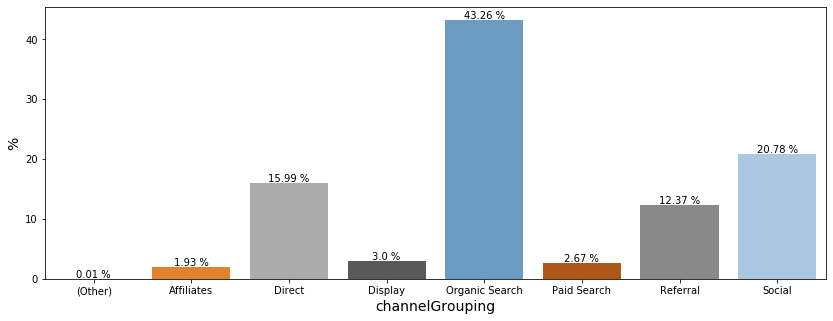

In [31]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'totals.transactionRevenue', data = channelGrouping_pct)
for index, row in channelGrouping_pct.iterrows():
    g.text(row.name, row['totals.transactionRevenue']+0.2, str(row['totals.transactionRevenue'])+" %", color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

In [32]:
channelGrouping_pct_spenders = pd.DataFrame(np.round(100*train_df.loc[train_df['totals.transactionRevenue']> 0].groupby('channelGrouping')['totals.transactionRevenue'].count()\
/train_df.groupby('channelGrouping')['totals.transactionRevenue'].count(),2)).reset_index().fillna(0)

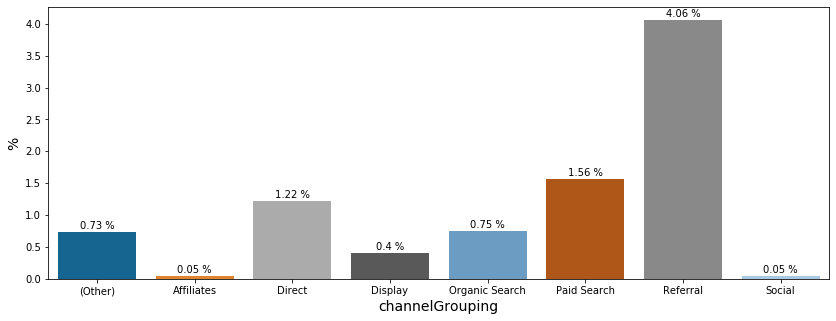

In [33]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'totals.transactionRevenue', data = channelGrouping_pct_spenders)
for index, row in channelGrouping_pct_spenders.iterrows():
    g.text(row.name, row['totals.transactionRevenue']+0.05, str(row['totals.transactionRevenue'])+" %", color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

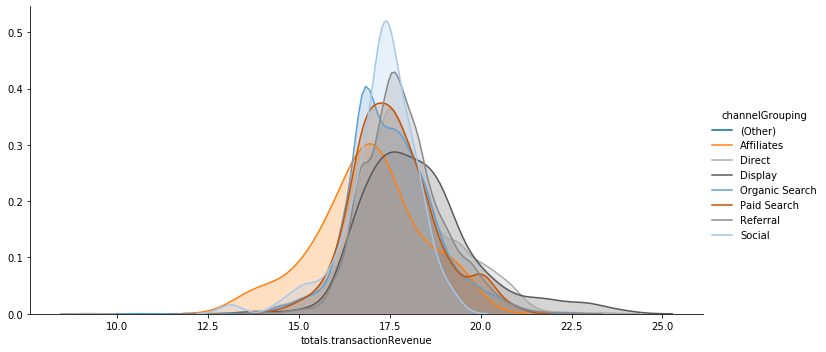

In [34]:
(sns.FacetGrid(train_df.loc[train_df['totals.transactionRevenue']> 0],hue='channelGrouping', height=5, aspect=2\
               ,hue_order = ['(Other)','Affiliates', 'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral', 'Social'])
 .map(sns.kdeplot, 'totals.transactionRevenue', shade=True )
 .add_legend()
);

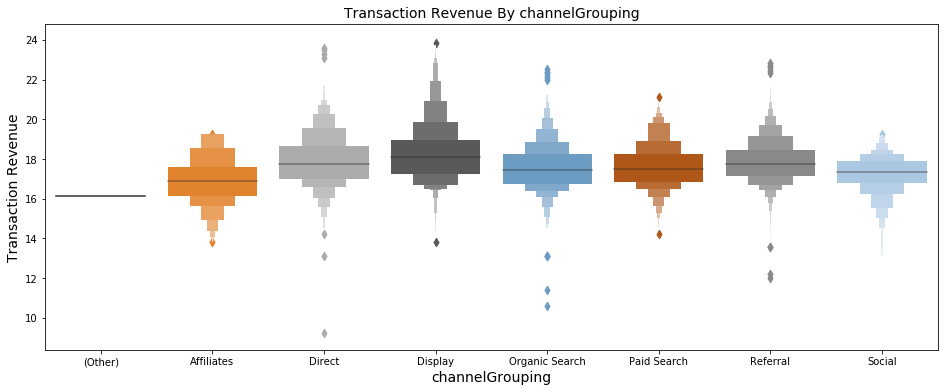

In [36]:
plt.figure(figsize = (16,6))
sns.boxenplot(x = 'channelGrouping', y='totals.transactionRevenue', data = train_df.loc[train_df['totals.transactionRevenue']> 0]\
             ,order = ['(Other)','Affiliates', 'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral', 'Social'])
plt.title('Transaction Revenue By channelGrouping', fontsize = 14)
plt.ylabel('Transaction Revenue', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14);

In [37]:
channelGrouping_revenue = pd.DataFrame(train_df.loc[train_df['totals.transactionRevenue']> 0].groupby('channelGrouping')['totals.transactionRevenue'].agg(['mean', 'std', 'median'])).reset_index()

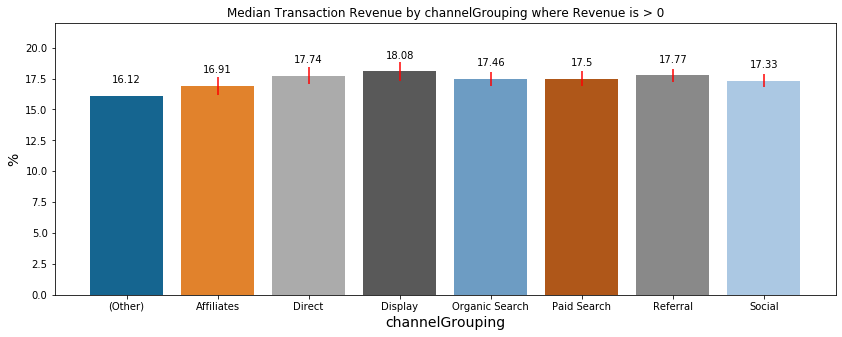

In [38]:
plt.figure(figsize = (14,5))
g = sns.barplot(x = 'channelGrouping', y = 'median', data = channelGrouping_revenue)
plt.errorbar(x = [0,1,2,3,4,5,6,7], y = channelGrouping_revenue['median'], yerr=channelGrouping_revenue['std']/2,fmt = 'none', c = 'r')
for index, row in channelGrouping_revenue.iterrows():
    g.text(row.name, row['median']+1.05, np.round(row['median'],2), color='black', ha="center")
plt.ylabel('%', fontsize = 14)
plt.xlabel('channelGrouping', fontsize = 14)
plt.ylim(0,22)
plt.title('Median Transaction Revenue by channelGrouping where Revenue is > 0');

Could play around with investigating all dimensions for ages.
will build an initial simple Random Forest Regressor to do some feature importance testing

To do that will need to sort out one hot encoding etc